# Performing Classification Tasks with Embeddings

In this notebook, we present a coincise and accessible introduction to **NLP embeddings** and delve into one of their potential applications in AI applications, namely *classification task*. As an illustrative example, we examine the case of classifying films genres based on plot descriptions, utilizing the *Hydra-Movie-Scrape* dataset sourced from [DataWorld](https://data.world/iliketurtles/movie-dataset): This notebook is structured as follows:
- **Introduction**: in this section, we provide a conceptual understanding of embeddings and highlight some their most common applications;
- **Data Preparation**: in this section, we conduct a brief exploration of the source dataset and undertake necessary steps to prepare the data for subsequent analysis;
- **Class Embeddings**: in this section, we show how we can easily generate text embeddings using the `embeddings.create` endpoint of the OpenAI API, applying it to the available classes pertinent to our classification problem;
- **Classying Movie Genres**: finally, we present a complete pipeline for the classification of movie genres using embeddings.

## Introduction

Roughly speaking, *embeddings* are a numerical representation of words, sentence or entire pieces of text, in terms of *vectors* in high-dimensional vector spaces. Before the advent of modern algorithms in deep learning, there were already exist several algorithms to convert words into numbers. The most common is probably the so-called *Count Vectorizer* method, which works as follow. 

Let suppose to have a vocabulary $V$ of $N$ words, each one identified by an index $i$ and that the word "Hello" is at position $i=100$. Then, a represention of the word "Hello" can be defined as:
$$ w^i_k = \delta_{ik}$$
where $\delta_{ik}$ is the Delta Kronecker, i.e. $\delta_{ik} = 1$ if $k=1$, otherwise 0.Despite its simplicity, this method has several drawbacks:
- when we have a large vocabulary, vector representations of words are *sparse* in nature, leading to computational inefficiency in most applications:
- vectorized words are all orthogonal to each others, therefore this method lacks of a *semantic* understanding of the language since similar words will still have a vanishing distance (we will return on the distance, hence *metric* definition in embedding spaces later)

These limitations were addressed **Word2Vec** algorithm, which is one of the pioneering techniques for learning word embeddings. The fundamental concept behind Word2Vec, and its derived methods, is to replace the discrete and sparse word vector represention with a *dense and continuous* representation. Consequently, the representation becomes *distributed*, meaning that the word is spread across all the dimensions. Moreover, Word2Vec leverages the concept of the so-called **Distributional Semantics**, which involves understanding a word's meaning through its contextual associations, that is its *context*.

<div style="text-align:center">
    <img src="images/word_embedding.png" alt="Image Alt Text" />
</div>

A comprehensive description of the Word2Vec algorithm is beyond the scope of this notebook. However, it is worth briefly highlighting how it operates, particularly the Skip-Gram implementation.

We consider all words $\vec{w}$ in our vocabulary $V$ and first initiliaze vector components to real random numbers. Let then consider a piece of text, where each word occupy a position defined by the index $p$. For each position, we define the *center word* as the word at position $p$ (i.e. $\vec{w}^p$), and the *context words* as words within the window $[p-m, p+m]$ where $m$ defines the window extent in terms of words number. The goal is to maximize the probability of the context words given the center word, in other words the probability of our model predicting the context words given the center word. This probability can be defined through the following *likelihood function*:
$$ L(\theta) = \prod_p \prod_{-m \leq j \leq m, j\neq 0} P(\vec{w}_{p+j} | \vec{w}_{p}; \theta)$$

The first product runs over the context window, the second runs over all available positions within the text. The above function can be written in a simpler form for maximization by taking the negative $\log$:
$$ J(\theta) = - \frac{1}{n_p} \log L(\theta) = - \frac{1}{n_p} \sum_p \sum_{-m \leq j \leq m, j\neq 0}P(\vec{w}_{p+j} | \vec{w}_{p}; \theta)$$
where $n_p$ is the number of positions within the text. There is just one parameter $\theta$ in our model equation that has to be determined in the training phase. Such parameter arises from the explicit representation of $P(w_{p+j} | w_{p})$ conditional probabilities. Indeed, these can be modeled as follows. Suppose that each word can be represented by two vectors, that we call $\vec{w}_c$ and $\vec{w_t}$, where the former is used when the word is a context word, while the latter when the word is a center word ($t$ stands for "target"). Then, the probability of observing the context word given the target word is the following softmax function:
$$ P(\vec{w}_c | \vec{w}_t) = \frac{\exp(\vec{w}_c^T \vec{w}_t)}{\sum_{p \in V} \vec{w}_{p, c}^T \vec{w}_t}$$
Basically, the numerator captures the distance between the context nd target words, i.e. their similarity. The denominator is the sum of the dot product between the target word and all words in the vocubolary and acts as a normalization constant so that probabilities all add up to 1.
Therefore, $\theta$ will be a vector containing all pair of vectors $\vec{w}_c$ and $\vec{w}_{t}$ for each word in the vocabulary. If the vocabulary size is $n_p$ and each vector lies in a $d$-dimensional vector space (the embedding space), then $\theta \in \mathcal{R}^{2dn_p}$. Its component can be then learned applied a optimization algorithm such as *gradient descent*. 

### Metrics in the embedding space: the cosine distance

Now, let's consider that we've generated embeddings for two words using an available embedding generation algorithm. As embeddings encode word semantics, we can compute the distance between two embeddings to reflect the similarity between the original words, by introducing a metric in the embedding space. Once more, a thorough analysis of potential metrics is beyond our current scope (extensive literature exists on metric spaces!). Here, we introduce the simplest form of distance, which is suitable for most AI applications: the **cosine distance**. The cosine distance between two vectors $\vec{u}, \vec{v}$ is defined as:
$$D(\vec{u}, \vec{v})  = 1 - S(\vec{u}, \vec{v})$$
where $S(\vec{u}, \vec{v})$ is the *cosine similarity* i.e.:
$$S(\vec{u}, \vec{v}) = \cos(\alpha) = \frac{\vec{u}^T \vec{v}}{||\vec{u}|| \ || \vec{v}||}$$
that is the cosine of the angle between the two vectors. Since $\cos(\alpha) \in [-1,1]$, the cosine distances ranges between 0 and 2. 

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px; border: 1px solid #87CEEB;">
    <strong>Math Curiosity!:</strong> Strictly speaking, the cosine distance is NOT a metric. Indeed, the cosine distance does not satisfy the so-called Scharwz inequality, i.e. $D(\vec{x}, \vec{z}) <= D(\vec{x}, \vec{y}) + D(\vec{x}, \vec{z})$. Furthermore, the cosine similarity $S(\cdot)$ itself is not a metric over $R^n$ since it is not defined whether one of the input is 0.
</div>

In the following, we will use the `distance` method of the `scipy`package to compute cosine distance between word embeddings.

### Embeddings in AI Application

Embeddings and their relative distances can be used in a variety of AI Applications but the most common are the followings:
- **Semantic Search**: the user input a query which is transformed into an embedding. Such embedding is matched with available embeddings (e.g. stored in a **vector database**) and the most similar are retrieved. The foundation of the technique lies again in the *distributional hypothesis*, namely that semantically similar texts are embedded more closely in the vector space;
- **Recommendation Engines**: a recommendation system can return the embeddings that most closely match embeddings representing user's interests. Suppose for example that we have access to the user history about his reading in an article magazine. We can average the embeddings relative to read documents to produce a "mean embedding" representing user's interest and match with all document embeddings to find the most similar, i.e. recommendable articles;
- **Classification Tasks**: again, we embed the text we want to classify and match with embeddings representing the available class descriptions. This is at times called **zero-shot classification**, since, unlike traditional supervise learning algorithms for classification such as *logistic regression* or *neural networks*, we do not use already labeled data. We just exploit the semantical similarity between data and class.

Here, we specifically focus on the third application and show how we can build a simple "classifier" based on embeddings.

## Data Preparation

Let's now proceed with coding to demonstrate how the process of generating and utilizing embeddings for classification is straightforward, thanks to the OpenAI API. First and foremost, we need to load the movie CSV file into a `pandas` dataframe and preprocess the data accordingly.

In [1]:
import pandas as pd
from typing import List, Dict
import json

# import openai, scipy, scikit learn and other useful packages
from openai import OpenAI
from scipy.spatial import distance

In [2]:
# Reading dataset
df_movie = pd.read_csv("Hydra-Movie-Scrape.csv")

In [3]:
df_movie.head(2)

,Title,Year,Summary,Short Summary,Genres,IMDB ID,Runtime,YouTube Trailer,Rating,Movie Poster,Director,Writers,Cast
0,Patton Oswalt: Annihilation,2017,"Patton Oswald, despite a personal tragedy, pro...","Patton Oswalt, despite a personal tragedy, pro...",Uncategorized,tt7026230,66,4hZi5QaMBFc,7.4,https://hydramovies.com/wp-content/uploads/201...,Bobcat Goldthwait,Patton Oswalt,Patton Oswalt
1,New York Doll,2005,A recovering alcoholic and recently converted ...,A recovering alcoholic and recently converted ...,Documentary|Music,tt0436629,75,jwD04NsnLLg,7.9,https://hydramovies.com/wp-content/uploads/201...,Greg Whiteley,Arthur Kane,Sylvain Sylvain


In this tutorial, we will focus mainly on three columns: **Title**, **Summary** and **Genres**. The first contains the title of the movie, the second a summary of the plot, the third the *genres*, i.e. the label we want to predict.

We can see that a movie can have multiple genres, separated by a "|", as displayed by the movie at index 0, *New York Doll*. For simplicity, we split the Genre string based on "|" and build a column with a list of genres.

In [4]:
def split_genre(split_str: str, sep: str) -> List[str]:
    '''
    Function accepting a string and a separator and return the splitted string as a list
    :param split_str: string to split
    :param sep: separator in the string
    :returns: the splitted string as a list
    '''
    return split_str.split(sep)

# Apply the function to the 'Genre' column
df_movie["Genres"] = df_movie["Genres"].apply(lambda x: split_genre(x, "|") )

In [5]:
# Distinct genres available in the dataset
df_movie["Genres"]

0                                       [Uncategorized]
1                                  [Documentary, Music]
2       [Adventure, Animation, Comedy, Family, Fantasy]
3          [Animation, Comedy, Family, Fantasy, Horror]
4                                               [Drama]
                             ...                       
3935                                 [Action, Thriller]
3936                            [Horror, Thriller, War]
3937                            [Comedy, Drama, Family]
3938                                           [Comedy]
3939                         [Action, Sci-Fi, Thriller]
Name: Genres, Length: 3940, dtype: object

Let identifiy how many distinc genres we have in our dataset. These will become the potential class of our classifier.

In [6]:
# FInd distinct genres
distinct_genres = df_movie.explode("Genres")["Genres"].unique()

In [7]:
distinct_genres

array(['Uncategorized', 'Documentary', 'Music', 'Adventure', 'Animation',
       'Comedy', 'Family', 'Fantasy', 'Horror', 'Drama', 'Sport',
       'Romance', 'Action', 'Sci-Fi', 'News', 'History', 'Thriller',
       'Western', 'Crime', 'Mystery', 'Biography', 'Musical', 'War',
       'Reality-TV'], dtype=object)

In [8]:
# Let's define a "Genre" classes:
genre_classes = [
    {"label": "Documentary", "description": "A movie whose genre is Documentary"},
    {"label": "Music", "description": "A movie whose genre is Music"},
    {"label": "Adventure", "description": "A movie whose genre is Adventure"},
    {"label": "Animation", "description": "A movie whose genre is Animation"},
    {"label": "Comedy", "description": "A movie whose genre is Comedy"},
    {"label": "Family", "description": "A movie whose genre is Family"},
    {"label": "Fantasy", "description": "A movie whose genre is Fantasy"},
    {"label": "Horror", "description": "A movie whose genre is Horror"},
    {"label": "Drama", "description": "A movie whose genre is Drama"},
    {"label": "Sport", "description": "A movie whose genre is Sport"},
    {"label": "Romance", "description": "A movie whose genre is Romance"},
    {"label": "Action", "description": "A movie whose genre is Action"},
    {"label": "Sci-Fi", "description": "A movie whose genre is Sci-Fi"},
    {"label": "News", "description": "A movie whose genre is News"},
    {"label": "History", "description": "A movie whose genre is History"},
    {"label": "Thriller", "description": "A movie whose genre is Thriller"},
    {"label": "Western", "description": "A movie whose genre is Western"},
    {"label": "Crime", "description": "A movie whose genre is Crime"},
    {"label": "Mystery", "description": "A movie whose genre is Mystery"},
    {"label": "Biography", "description": "A movie whose genre is Biography"},
    {"label": "Musical", "description": "A movie whose genre is Musical"},
    {"label": "War", "description": "A movie whose genre is War"},
    {"label": "Reality-TV", "description": "A movie whose genre is Reality-TV"}
]

Unfortunately, the available data do not provide a lot of information about each movie, except from the Title (which at times can be very informative though) and a plot summary. We will exploit both this information, combining them into a single column.

In [9]:
# Now we create a list of dictionary where each dictionary contains title and the true genre, and a concatenation
# title and summary
def create_text_string(title: str, summary: str) -> str:
    return f"""Title: {title}
Summary: {summary}"""

In [10]:
df_movie["Title+Summary"] = df_movie.apply(lambda row: create_text_string(row['Title'], row['Summary']), axis=1)

In [11]:
df_movie["Title+Summary"].head(2)

0    Title: Patton Oswalt: Annihilation\nSummary: P...
1    Title: New York Doll\nSummary: A recovering al...
Name: Title+Summary, dtype: object

Now that we have a single column for both Title and Summary, let transform our `pandas` dataframe into a list of dictionaries with just the relevant information:

In [12]:
movies_main_info = [
    {
        "Title" : row["Title"],
        "Genres": row["Genres"],
        "Text": row["Title+Summary"]
    }
    for i, row in df_movie.iterrows()
]

In [13]:
movies_main_info[0]

{'Title': 'Patton Oswalt: Annihilation',
 'Genres': ['Uncategorized'],
 'Text': 'Title: Patton Oswalt: Annihilation\nSummary: Patton Oswald, despite a personal tragedy, produces his best standup yet. Focusing on the tribulations of the Trump era and life after the loss of a loved one, Patton Oswald continues his journey to contribute joy to the world.'}

## Class Embeddings

We now possess all the necessary data to generate embeddings. As initial step,  we generate embeddings for the class descriptions. However, before proceeding, it's essential to create an instance of the OpenAI class and provide our `api_key`.

In [14]:
file = open("conf.json")
conf_json = json.load(file)

In [15]:
# create OpenAi client
client = OpenAI(api_key=conf_json["api_key"])

Of course, generating embeddings by through calls to the OpenAI API comes with some cost. The pricing model revolves around **tokens**, which represents fragments of word processed. Fortunately, there exists a helpful package called `tiktoken`that aids in estimating the cost for embeddings generation. First of all, we must calculate the total number of tokens generated by our embedding model for the text being processed. Then, multiply this figure by the cost per token. The latter, for the OpenAI `text-embedding-ada-002` - which is the model we will use in this tutorial - is around 0.0001 dollar per 1K tokens.

In [16]:
import tiktoken

enc = tiktoken.encoding_for_model("text-embedding-ada-002")

In [17]:
def calculate_total_tokens(documents: list) -> int:
    '''
    Function computing the total number of tokens of a list of documents

    :params documents: list of documents
    :returns: total tokens

    '''
    return sum(len(enc.encode(text)) for text in documents)

In [18]:
class_tokens = calculate_total_tokens([genre_class["description"] for genre_class in genre_classes])

In [19]:
# estimating cost using the OpenAI Cost per token
cost_per_1k_tokens = 0.0001
print("Cost of Class Embeddings: ", cost_per_1k_tokens * class_tokens/1000) 

Cost of Class Embeddings:  1.4100000000000002e-05


Similarly, we can estimate the cost of embedding the movie Title+Summary texts:

In [20]:
movie_text_tokens = calculate_total_tokens([movie_text["Text"] for movie_text in movies_main_info])

In [21]:
print("Cost of Movie Text Embeddings: ", cost_per_1k_tokens * movie_text_tokens/1000) 

Cost of Movie Text Embeddings:  0.0458774


Generating the embeddings for the text information avaiable for movies in our movie dataset costs just 4 cents. The reason is that we do not have large portion of text describing movies plot. Of course, small pieces of information may lead to poor performance of our embeddings classifier but at the same time long text descriptions may lead to high costs without real advanteges for the class predictions. 

Let's code a function to produce the embedding of a given text. In addition, let's also write a `timer` decorator to monitor the execution time of embeddings generation.

In [22]:
import time

# A function to decorate other functions to return execution time
def timer(func):
    def wrapper(*args, **kwargs):
        
        start_time = time.time()
        
        result = func(*args, **kwargs)
        
        end_time = time.time()
        
        execution_time = (end_time - start_time) / 60
        print(f"Execution time of {func.__name__}: {execution_time} minutes")
        
        return result
    return wrapper

In [23]:
# Now we define a function to generate embeddings
@timer
def create_embeddings(text_list: List[str]) -> List[list]:
    '''
    Function generating the embeddings of a text_list making calls to embeddings.create OpenAI API endpoint

    :params text_list: a list of text documents
    :returns: the embedding vector as a list

    '''

    def get_embedding_from_openai(text: str) -> List[float]:
        response = client.embeddings.create(
            model = "text-embedding-ada-002",
            input=text
        )
    
        return response.data[0].embedding

    return [get_embedding_from_openai(text) for text in text_list]

In [24]:
# Let first create the embeddings of genres
class_descriptions = [genre["description"] for genre in genre_classes]

In [25]:
class_embeddings = create_embeddings(class_descriptions)

Execution time of create_embeddings: 0.10600130160649618 minutes


### Embeddings Dimensions and Visualization with t-SNE

In [26]:
# Check dimensions
print(f"Dimension of the class_embeddings: {len(class_embeddings)}")
print(f"Dimension of each embedding: {len(class_embeddings[0])}")

Dimension of the class_embeddings: 23
Dimension of each embedding: 1536


We can see that `class_embeddings`has dimension `23`, which is the number of available classes (i.e. genres). Each embedding is a 1536-dimensional vector, since the method we are using, `text-embedding-ada-002` produces embeddings of such dimensionality. To visualize embeddings and verify if semantically similar words are proximate, we can project this 1536-dimensional embedding space into a lower-dimensional space, such as a 2D Euclidean space. It's important to note that in undertaking such a projection, a considerable amount of information is lost, thus dimensionality reduction must be used with caution. Nonetheless, this approach can provide us with a qualitative understanding of how embeddings capture semantics.

We can use *t-SNE* (**t-Distributed stochastic neighbor embedding**) as implemented in `sklearn` to perform such a dimensionality reduction.

In [27]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Instantiate a class of t-SNE with perplexity 5 (< len(class_embeddings)
tsne = TSNE(n_components=2, perplexity=5) 

In [28]:
class_embeddings_2d = tsne.fit_transform(np.array(class_embeddings))

In [29]:
# We perform a quick clustering to cluster nearby points for the sake of visualization
num_clusters = 7

# Fit K-means clustering model
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(class_embeddings_2d)

# Get cluster labels
cluster_labels = kmeans.labels_

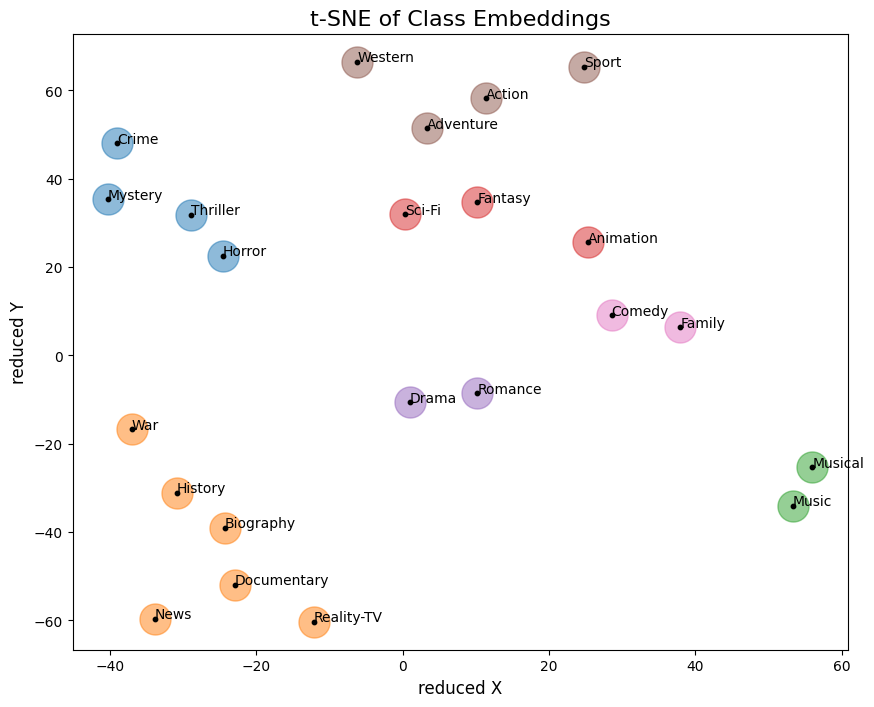

In [45]:
# Increase the size of the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot with clustered colors
for i in range(num_clusters):
    cluster_points = class_embeddings_2d[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=500, label=f'Cluster {i+1}', alpha=0.5)
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {i+1}', color="black")
    
labels = [genre["label"] for genre in genre_classes]

for i, label in enumerate(labels):
	plt.annotate(label, (class_embeddings_2d[i, 0], class_embeddings_2d[i, 1]))

# Customize axes labels, titles, etc. if needed
ax.set_xlabel('reduced X', fontsize=12)
ax.set_ylabel('reduced Y', fontsize=12)
ax.set_title('t-SNE of Class Embeddings', fontsize=16)

plt.show()

As expected, similar genres possess embeddings that are proximate in the geometric space and therefore cluster in the reduced dimensional space.

## Classifying Movies Genres

We can now generate embeddings for each movie text (Title+Summary) and for each embedding compute the distance with each class embeddings to find the most closest class. Let's try first with a single example:

In [46]:
# Let's define now a function to find the N closest embeddings matches usine cosine distance
def find_n_closest(query_embedding: List[float], embeddings: List[float], n=3) -> List[Dict]:
    '''
    Function returning the n closest embeddings to the query_embedding.

    :params query_embedding: the input embedding
    :params embeddings: the list of embeddings to match with
    :params n: the number of closest math to return

    :returns: a list with n elements. Each element is dictionary with distance values and matched embedding index
    '''
    
    distances = []
    for index, embedding in enumerate(embeddings):
        dist = distance.cosine(query_embedding, embedding)
        distances.append({"distance": dist, "index" : index})
    
    distances_sorted = sorted(distances, key=lambda x: x["distance"])
    
    return distances_sorted[0:n]

In [47]:
# We embed the movie text
single_movie_embedding = create_embeddings([movies_main_info[10]["Text"]])[0]

Execution time of create_embeddings: 0.004062084356943766 minutes


In [48]:
movies_main_info[10]

{'Title': 'Forever My Girl',
 'Genres': ['Drama', 'Music', 'Romance'],
 'Text': 'Title: Forever My Girl\nSummary: After being gone for a decade a country star returns home to the love he left behind.'}

In [49]:
# Find the three closest class embeddings to the movie selected above
n_hits = find_n_closest(single_movie_embedding, class_embeddings, n=3)
n_hits

[{'distance': 0.2086858468468431, 'index': 10},
 {'distance': 0.21946885892939683, 'index': 20},
 {'distance': 0.22021874596644075, 'index': 1}]

In [50]:
for hit in n_hits:
    class_matched = genre_classes[hit["index"]]["label"]
    print(f"Matched Genres: {class_matched}, Current Genres: {movies_main_info[10]['Genres']}")

Matched Genres: Romance, Current Genres: ['Drama', 'Music', 'Romance']
Matched Genres: Musical, Current Genres: ['Drama', 'Music', 'Romance']
Matched Genres: Music, Current Genres: ['Drama', 'Music', 'Romance']


For movie at index 10, namely *"Forever My Girl"*, the embeddings classifier has matched the following three genres: **Romance**, **Musical** and **Music**. Notably, Romance and Music are correctly identified. The embedding classifier also matched *Musical* because is this class is very close to *Music* in the geometric space. This misclassification could be due to either the lack of precise descriptions for our classes (which would differentiate Music from Musical) or the absence of key information in the title and summary text, leading to a match with *Drama* instead of Musical. Nonetheless, this outcome is intriguing given the limited information we are utilizing.

Let apply the above method to more movies in our dataset. Since this operation may take a lot of time if done on the whole set, we restrict the computation to just a sumbsaple of 200 movies.

In [52]:
# Create all embeddings
all_movies_embeddings = create_embeddings([movie["Text"] for movie in movies_main_info[0:201]])

Execution time of create_embeddings: 0.8540511329968771 minutes


In [53]:
len(all_movies_embeddings[0]), len(all_movies_embeddings)

(1536, 201)

In [55]:
def get_class_matched(hits: List[Dict], class_dict: List[Dict]) -> List:
    '''
    Function returning the list of class matched

    :params hits: the list of matched embeddings as dictionary of distance and indeces
    :params class_dict: the list of class info

    :returns: the list of matched classes
    '''
    return [class_dict[hit["index"]]["label"] for hit in hits]

In [57]:
predicted_class_list = []

for i, movie_embedding in enumerate(all_movies_embeddings):
    # Find n=5 closest
    hits = find_n_closest(movie_embedding, class_embeddings, n=5)

    # Get the list of matched classes
    matched_list = get_class_matched(hits, genre_classes)

    # Appending result to the output list
    predicted_class_list.append([movies_main_info[i]['Title'], movies_main_info[i]['Genres'], matched_list])

In [121]:
# Store the predictions into a new pandas dataframe:
df_predictions = pd.DataFrame(predicted_class_list, columns=["Title", "Current_Genres", "Predicted_Genres"])

In [122]:
df_predictions

,Title,Current_Genres,Predicted_Genres
0,Patton Oswalt: Annihilation,[Uncategorized],"[War, Biography, Comedy, Documentary, Reality-TV]"
1,New York Doll,"[Documentary, Music]","[Horror, Thriller, Music, Mystery, Reality-TV]"
2,Mickey's Magical Christmas: Snowed in at the H...,"[Adventure, Animation, Comedy, Family, Fantasy]","[Animation, Family, Fantasy, Comedy, Musical]"
3,Mickey's House of Villains,"[Animation, Comedy, Family, Fantasy, Horror]","[Animation, Family, Fantasy, Comedy, Horror]"
4,And Then I Go,[Drama],"[Drama, Thriller, Family, Horror, Crime]"
...,...,...,...
196,My Life as a Zucchini,"[Animation, Comedy, Drama]","[Family, Comedy, Mystery, Crime, Fantasy]"
197,The Salesman,"[Drama, Thriller]","[Drama, Romance, Thriller, Mystery, Comedy]"
198,I Am Not Your Negro,[Documentary],"[Biography, History, Drama, Documentary, News]"
199,Lady Bird,"[Comedy, Drama]","[Biography, Romance, Drama, Adventure, Comedy]"


### Measure Accuracy

How can we assess the accuracy of our classifier? As an initial and straightforward metric, we can utilize the **fraction of misclassified genres**. Prior to computing the accuracy, we should recognize that the number of predicted genres and actual genres may not always align. This discrepancy arises because we consistently retrieve the top 5 closest matches, as some films may belong to multiple genres. While a more sophisticated approach could involve setting a threshold in the cosine distance and ceasing to return matches above this threshold, for our current task, we can stay simple. We can achieve this by merely truncating the predicted genres list in the `Predicted_Genres`column to match the length of the corresponding actual genre list in the `Current_Genres` column.

In [123]:
def truncate_prediced_genres(row):
    current_genres = row['Current_Genres']
    predicted_genres = row['Predicted_Genres']

    return predicted_genres[:len(current_genres)] if len(current_genres) <= len(predicted_genres) else predicted_genres

In [124]:
df_predictions["Truncated_Predicted_Genres"] = df_predictions.apply(truncate_prediced_genres, axis=1)

In [125]:
df_predictions

,Title,Current_Genres,Predicted_Genres,Truncated_Predicted_Genres
0,Patton Oswalt: Annihilation,[Uncategorized],"[War, Biography, Comedy, Documentary, Reality-TV]",[War]
1,New York Doll,"[Documentary, Music]","[Horror, Thriller, Music, Mystery, Reality-TV]","[Horror, Thriller]"
2,Mickey's Magical Christmas: Snowed in at the H...,"[Adventure, Animation, Comedy, Family, Fantasy]","[Animation, Family, Fantasy, Comedy, Musical]","[Animation, Family, Fantasy, Comedy, Musical]"
3,Mickey's House of Villains,"[Animation, Comedy, Family, Fantasy, Horror]","[Animation, Family, Fantasy, Comedy, Horror]","[Animation, Family, Fantasy, Comedy, Horror]"
4,And Then I Go,[Drama],"[Drama, Thriller, Family, Horror, Crime]",[Drama]
...,...,...,...,...
196,My Life as a Zucchini,"[Animation, Comedy, Drama]","[Family, Comedy, Mystery, Crime, Fantasy]","[Family, Comedy, Mystery]"
197,The Salesman,"[Drama, Thriller]","[Drama, Romance, Thriller, Mystery, Comedy]","[Drama, Romance]"
198,I Am Not Your Negro,[Documentary],"[Biography, History, Drama, Documentary, News]",[Biography]
199,Lady Bird,"[Comedy, Drama]","[Biography, Romance, Drama, Adventure, Comedy]","[Biography, Romance]"


In [126]:
# Let filter the Uncategorized cases
df_predictions = df_predictions[df_predictions["Current_Genres"].apply(lambda x: x != ["Uncategorized"])]

In [127]:
def compare_lists(first_list: List, second_list: List) -> int:
    '''
    Function comparing two lists. If lists contain at least one element in common, return 1 else return 0
    '''

    return 1 if bool(set(first_list) & set(second_list)) else 0

In [128]:
df_predictions = df_predictions.copy()
df_predictions.loc[:, "right_classification"] = df_predictions.apply(lambda row: compare_lists(row["Current_Genres"], row["Truncated_Predicted_Genres"]), axis=1)

In [129]:
df_predictions

,Title,Current_Genres,Predicted_Genres,Truncated_Predicted_Genres,right_classification
1,New York Doll,"[Documentary, Music]","[Horror, Thriller, Music, Mystery, Reality-TV]","[Horror, Thriller]",0
2,Mickey's Magical Christmas: Snowed in at the H...,"[Adventure, Animation, Comedy, Family, Fantasy]","[Animation, Family, Fantasy, Comedy, Musical]","[Animation, Family, Fantasy, Comedy, Musical]",1
3,Mickey's House of Villains,"[Animation, Comedy, Family, Fantasy, Horror]","[Animation, Family, Fantasy, Comedy, Horror]","[Animation, Family, Fantasy, Comedy, Horror]",1
4,And Then I Go,[Drama],"[Drama, Thriller, Family, Horror, Crime]",[Drama],1
5,An Extremely Goofy Movie,"[Animation, Comedy, Family, Sport]","[Comedy, Family, Animation, Sport, Adventure]","[Comedy, Family, Animation, Sport]",1
...,...,...,...,...,...
196,My Life as a Zucchini,"[Animation, Comedy, Drama]","[Family, Comedy, Mystery, Crime, Fantasy]","[Family, Comedy, Mystery]",1
197,The Salesman,"[Drama, Thriller]","[Drama, Romance, Thriller, Mystery, Comedy]","[Drama, Romance]",1
198,I Am Not Your Negro,[Documentary],"[Biography, History, Drama, Documentary, News]",[Biography],0
199,Lady Bird,"[Comedy, Drama]","[Biography, Romance, Drama, Adventure, Comedy]","[Biography, Romance]",0


In [130]:
# Now we compute accuracy:
def get_accuracy(classification_vector: List):
    return sum(classification_vector)/len(classification_vector)

In [131]:
movie_genres_classification_accuracy = get_accuracy(df_predictions["right_classification"])

In [132]:
print(f"The accuracy for genre classification on the toy dataset using embeddings is: {movie_genres_classification_accuracy}")

The accuracy for genre classification on the toy dataset using embeddings is: 0.7222222222222222
